In [1]:
import pandas as pd
import numpy as np

users = pd.read_csv(
    "users.csv",
    parse_dates=["signup_date"],
    keep_default_na=False,        # do NOT auto-convert 'NA', 'N/A', etc. to NaN
    na_values=["", " ", "NaN"]    # still treat true blanks as missing
)

# (optional) normalise/spaces -> NA
users = users.apply(
    lambda s: s.replace(r"^\s*$", pd.NA, regex=True) if s.dtype == "object" else s
)

# sanity check
print(users["region"].value_counts(dropna=False))
print("Missing % in region:", users["region"].isna().mean())

region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0


In [2]:
import pandas as pd

# Helper: keep "NA" literal, but treat blanks and "N/A" as missing
NA_SAFE = dict(
    keep_default_na=False,                 # don't auto-convert "NA"/"na" to NaN
    na_values=["", " ", "NaN", "nan", "N/A", "n/a"]  # still treat true blanks & "N/A" as NaN
)

# Load CSVs (dates parsed as before)
users    = pd.read_csv("users.csv", parse_dates=["signup_date"], **NA_SAFE)
sessions = pd.read_csv("sessions.csv", parse_dates=["session_start", "session_end"], **NA_SAFE)
events   = pd.read_csv("events.csv", parse_dates=["ts"], **NA_SAFE)
billing  = pd.read_csv("billing.csv", parse_dates=["month"], **NA_SAFE)

# -----------------------------
# Quick info and missing values
# -----------------------------
for df_name, df in zip(["users", "sessions", "events", "billing"], [users, sessions, events, billing]):
    print(f"\n=== {df_name.upper()} INFO ===")
    df.info()
    print("\nMissing values per column:")
    print(df.isna().sum())



=== USERS INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              100000 non-null  object        
 1   signup_date          100000 non-null  datetime64[ns]
 2   plan_tier            100000 non-null  object        
 3   company_size         100000 non-null  object        
 4   region               100000 non-null  object        
 5   industry             100000 non-null  object        
 6   acquisition_channel  100000 non-null  object        
 7   is_enterprise        100000 non-null  bool          
 8   churned_30d          100000 non-null  int64         
 9   churned_90d          100000 non-null  int64         
 10  downgraded           100000 non-null  int64         
 11  expansion_event      100000 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(6)
me

In [3]:
# Optional: convert whitespace-only strings to NA across object columns (safety net)
for df in (users, sessions, events, billing):
    obj_cols = df.select_dtypes(include="object").columns
    df[obj_cols] = df[obj_cols].replace(r"^\s*$", pd.NA, regex=True)

# -----------------------------
# IMPUTE APP VERSIONS
# -----------------------------
# For example, sessions may have 'app_version' column
if "app_version" in sessions.columns:
    # Fill missing app_version with a placeholder "unknown"
    sessions["app_version"] = sessions["app_version"].fillna("unknown")

# For events dataset
if "app_version" in events.columns:
    events["app_version"] = events["app_version"].fillna("unknown")

# Quick sanity check that "NA" is kept as a category, not NaN
print(users["region"].value_counts(dropna=False).head(10))
print("Missing % in region:", users["region"].isna().mean())

# Check app_version imputation
if "app_version" in sessions.columns:
    print("Sessions app_version counts:\n", sessions["app_version"].value_counts(dropna=False).head(10))
if "app_version" in events.columns:
    print("Events app_version counts:\n", events["app_version"].value_counts(dropna=False).head(10))


region
NA       38224
APAC     27810
EU       25960
LATAM     8006
Name: count, dtype: int64
Missing % in region: 0.0
Sessions app_version counts:
 app_version
1.0.0    5667
1.9.1    5666
1.3.0    5666
1.5.5    5664
1.1.3    5662
1.9.0    5658
1.8.4    5647
1.9.4    5635
1.8.5    5624
1.6.2    5611
Name: count, dtype: int64


In [4]:
# 30-day churn rate
churn_rate_30d = users["churned_30d"].mean()
print(f"30-day churn rate: {churn_rate_30d:.2%}")

# 90-day churn rate
churn_rate_90d = users["churned_90d"].mean()
print(f"90-day churn rate: {churn_rate_90d:.2%}")



30-day churn rate: 12.96%
90-day churn rate: 22.99%


In [5]:
# Aggregate sessions per user
session_stats = sessions.groupby("user_id").agg(
    sessions_count=("session_id", "count"),
    avg_session_length=("session_length_sec", "mean")
).reset_index()

# Merge with 30d + 90d churn labels
engagement = users[["user_id", "churned_30d", "churned_90d"]] \
    .merge(session_stats, on="user_id", how="left")

# Compare churned vs retained (30d)
print("Engagement by 30d churn status:\n")
print(engagement.groupby("churned_30d")[["sessions_count", "avg_session_length"]].mean())

# Compare churned vs retained (90d)
print("\nEngagement by 90d churn status:\n")
print(engagement.groupby("churned_90d")[["sessions_count", "avg_session_length"]].mean())


Engagement by 30d churn status:

             sessions_count  avg_session_length
churned_30d                                    
0                  4.864032          839.461520
1                  3.482207          839.124266

Engagement by 90d churn status:

             sessions_count  avg_session_length
churned_90d                                    
0                  5.083332          839.376957
1                  3.007022          839.632376


In [6]:
session_stats = sessions.groupby("user_id").agg(
    avg_session_length=("session_length_sec", "mean"),
    sessions_per_week=("session_id", lambda x: float(x.nunique())/4),
    active_days=("session_start", lambda x: float(x.dt.date.nunique())),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

print(session_stats[["sessions_per_week"]])


       sessions_per_week
0                   0.25
1                   0.25
2                   1.00
3                   0.50
4                   1.25
...                  ...
71528               2.75
71529               2.25
71530               0.50
71531               2.25
71532               1.25

[71533 rows x 1 columns]


In [7]:
import numpy as np
import pandas as pd

# Ensure datetime
sessions = sessions.copy()
sessions["session_start"] = pd.to_datetime(sessions["session_start"])

# (Optional) de-dup in case the same session_id appears multiple times
sessions = sessions.drop_duplicates(subset=["user_id", "session_id"])

# Per-user aggregates
g = sessions.groupby("user_id")

session_stats = g.agg(
    sessions_count=("session_id", "nunique"),
    avg_session_length=("session_length_sec", "mean"),
    first_seen=("session_start", "min"),
    last_seen=("session_start", "max"),
    active_days=("session_start", lambda x: x.dt.date.nunique()),
    device_diversity=("device", "nunique"),
    os_diversity=("os", "nunique")
).reset_index()

# Compute weeks observed per user (avoid divide-by-zero for single-day users)
span_days = (session_stats["last_seen"] - session_stats["first_seen"]).dt.total_seconds() / 86400.0
weeks_observed = np.maximum(span_days / 7.0, 1/7)   # at least one day (~1/7 week)

session_stats["sessions_per_week"] = session_stats["sessions_count"] / weeks_observed

# Inspect
session_stats[["user_id", "sessions_count", "first_seen", "last_seen", "sessions_per_week"]].head()


,user_id,sessions_count,first_seen,last_seen,sessions_per_week
0,0000093e-7258-43c0-b212-ea7212795ddf,1,2025-04-04 22:01:25.065312987,2025-04-04 22:01:25.065312987,7.000000
1,0006fdbd-c35d-4c0d-a948-e8ee10f279d5,1,2025-02-12 23:47:41.761338189,2025-02-12 23:47:41.761338189,7.000000
2,0007ee13-0c60-4865-9464-914b2df654df,4,2025-03-21 12:50:37.457893086,2025-06-06 10:27:59.068288586,0.364105
3,000836d5-0777-4310-a8a5-5c857d2ea5e5,2,2024-07-15 12:25:29.926266202,2024-09-15 23:33:35.673589849,0.224129
4,0008a782-5378-45a1-b332-10c73c4296ff,5,2025-02-20 17:05:06.077705968,2025-07-06 16:15:29.456901849,0.257418


In [8]:
# Event stats per user (30D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_30d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_30d")[["fail_rate", "avg_latency", "features_used"]].mean())

# Event stats per user (90D)
event_stats = events.groupby("user_id").agg(
    fail_rate=("success", lambda x: 1 - x.mean()),
    avg_latency=("latency_ms", "mean"),
    features_used=("feature_name", "nunique")
).reset_index()

exp = users[["user_id", "churned_90d"]].merge(event_stats, on="user_id", how="left")

print(exp.groupby("churned_90d")[["fail_rate", "avg_latency", "features_used"]].mean())

             fail_rate  avg_latency  features_used
churned_30d                                       
0             0.069980   258.354448        2.07476
1             0.071522   275.063462        1.82014
             fail_rate  avg_latency  features_used
churned_90d                                       
0             0.070276   255.355131       2.106863
1             0.069418   285.484804       1.734101


In [9]:
# Aggregate billing by user (30D) in percentage 
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_30d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_30d")[["overdue", "discount", "avg_tickets"]].mean())

# Aggregate billing by user (90D)
billing_stats = billing.groupby("user_id").agg(
    overdue=("invoices_overdue", "mean"),
    discount=("discount_applied", "mean"),
    avg_tickets=("support_ticket_count", "mean")
).reset_index()

bill = users[["user_id", "churned_90d"]].merge(billing_stats, on="user_id", how="left")

print(bill.groupby("churned_90d")[["overdue", "discount", "avg_tickets"]].mean())



              overdue  discount  avg_tickets
churned_30d                                 
0            0.024312  0.071200     0.497307
1            0.026551  0.047302     0.296783
              overdue  discount  avg_tickets
churned_90d                                 
0            0.023842  0.077167     0.540442
1            0.027146  0.037744     0.239792


In [10]:
# Churn by plan tier (30D)
seg_30 = users.groupby("plan_tier")["churned_30d"].mean()
print("30D churn by plan tier:\n", seg_30)

# Churn by acquisition channel (30D)
seg2_30 = users.groupby("acquisition_channel")["churned_30d"].mean()
print("30D churn by acquisition channel:\n", seg2_30)

# Churn by plan tier (90D)
seg_90 = users.groupby("plan_tier")["churned_90d"].mean()
print("90D churn by plan tier:\n", seg_90)

# Churn by acquisition channel (90D)
seg2_90 = users.groupby("acquisition_channel")["churned_90d"].mean()
print("90D churn by acquisition channel:\n", seg2_90)



30D churn by plan tier:
 plan_tier
free        0.165465
premium     0.058785
standard    0.099987
Name: churned_30d, dtype: float64
30D churn by acquisition channel:
 acquisition_channel
ads         0.137432
outbound    0.133694
partner     0.124769
seo         0.125666
Name: churned_30d, dtype: float64
90D churn by plan tier:
 plan_tier
free        0.318936
premium     0.063667
standard    0.151543
Name: churned_90d, dtype: float64
90D churn by acquisition channel:
 acquisition_channel
ads         0.236924
outbound    0.237952
partner     0.223436
seo         0.226044
Name: churned_90d, dtype: float64


In [11]:
# If needed (once):
# !pip install imbalanced-learn xgboost packaging

import numpy as np
import pandas as pd
import sklearn
from packaging import version

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # <-- imblearn Pipeline (required for SMOTE step)
from xgboost import XGBClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.20
LABEL = "churned_90d"   # change to "churned_30d" if you want 30-day churn


In [12]:
req_sess = {"user_id","session_id","session_start","session_length_sec","device","os"}
missing = req_sess - set(sessions.columns)
if missing: raise ValueError(f"sessions missing columns: {missing}")

sess_agg = sessions.groupby("user_id").agg(
    sessions_count=("session_id","nunique"),
    sessions_days_active=("session_start", lambda x: float(pd.to_datetime(x).dt.date.nunique())),
    avg_session_length=("session_length_sec","mean"),
    device_diversity=("device","nunique"),
    os_diversity=("os","nunique"),
)
sess_agg["sessions_per_week"] = sess_agg["sessions_count"] / np.maximum(sess_agg["sessions_days_active"]/7.0, 1e-6)

# also first_seen / last_seen to build recency later
seen_agg = sessions.groupby("user_id").agg(
    first_seen=("session_start","min"),
    last_seen =("session_end","max")
)
print("✅ Session features built.")


✅ Session features built.


In [13]:
req_evt = {"user_id","feature_name","latency_ms","success","duration_ms"}
missing = req_evt - set(events.columns)
if missing: raise ValueError(f"events missing columns: {missing}")

evt_agg = events.groupby("user_id").agg(
    features_used=("feature_name","nunique"),
    avg_latency=("latency_ms","mean"),
    fail_rate=("success", lambda x: 1.0 - x.mean()),
    events_count=("feature_name","size"),
    avg_event_duration=("duration_ms","mean"),
)

# counts of the globally most-used features (helps models)
topN = 10
top_feats = events["feature_name"].value_counts().nlargest(topN).index.tolist()
feat_pivot = (events[events["feature_name"].isin(top_feats)]
              .groupby(["user_id","feature_name"]).size()
              .unstack(fill_value=0))
feat_pivot.columns = [f"feat_use__{c}" for c in feat_pivot.columns]
print("✅ Event features built.")


✅ Event features built.


In [14]:
req_bill = {"user_id","month","plan_tier","active_seats","mrr","discount_applied","invoices_overdue","support_ticket_count"}
missing = req_bill - set(billing.columns)
if missing: raise ValueError(f"billing missing columns: {missing}")

billing_sorted = billing.sort_values(["user_id","month"])

# Latest snapshot per user
bill_latest = billing_sorted.groupby("user_id").tail(1).set_index("user_id")
bill_latest_small = bill_latest[["plan_tier","active_seats","mrr","discount_applied","invoices_overdue","support_ticket_count"]]
bill_latest_small = bill_latest_small.add_prefix("latest_")

# Last 3 months aggregates per user
def last_n_months(df, n=3):
    return (df.sort_values("month").groupby("user_id").tail(n))

bill_last3 = last_n_months(billing_sorted, 3)
bill_agg3 = bill_last3.groupby("user_id").agg(
    mrr_mean_3m=("mrr","mean"),
    mrr_std_3m=("mrr","std"),
    seats_mean_3m=("active_seats","mean"),
    discount_any_3m=("discount_applied", lambda x: float(np.any(x.astype(int)==1))),
    overdue_any_3m=("invoices_overdue", lambda x: float(np.any(x.astype(int)==1))),
    support_tix_sum_3m=("support_ticket_count","sum"),
)
print("✅ Billing features built.")


✅ Billing features built.


In [15]:
# Base table with label
user_meta = users.set_index("user_id")
y = user_meta[LABEL].astype(int)

# Join all features
feat = (user_meta
        .join(sess_agg, how="left")
        .join(seen_agg,  how="left")
        .join(evt_agg,   how="left")
        .join(feat_pivot, how="left")
        .join(bill_agg3,  how="left")
        .join(bill_latest_small, how="left"))

# Fill count-like NaNs with 0
count_like = [c for c in feat.columns if c.endswith("_count") or c.startswith("feat_use__")]
feat[count_like] = feat[count_like].fillna(0)

# Observation end date (max timestamp across tables)
candidates = []
if "signup_date" in users.columns:
    candidates.append(pd.to_datetime(users["signup_date"], errors="coerce").max())
if {"session_end","session_start"}.issubset(sessions.columns):
    candidates += [
        pd.to_datetime(sessions["session_end"], errors="coerce").max(),
        pd.to_datetime(sessions["session_start"], errors="coerce").max(),
    ]
if "ts" in events.columns:
    candidates.append(pd.to_datetime(events["ts"], errors="coerce").max())
if "month" in billing.columns:
    candidates.append(pd.to_datetime(billing["month"], errors="coerce").max())
obs_end = pd.to_datetime(max([c for c in candidates if pd.notna(c)]))

# Ensure datetime types
for col in ["first_seen","last_seen"]:
    if col in feat.columns:
        feat[col] = pd.to_datetime(feat[col], errors="coerce")

# Recency/tenure features
if "last_seen" in feat.columns:
    feat["days_since_last_seen"] = (obs_end - feat["last_seen"]).dt.days
if {"first_seen","last_seen"}.issubset(feat.columns):
    span = (feat["last_seen"] - feat["first_seen"]).dt.days
    feat["activity_span_days"] = span.clip(lower=0)
if "signup_date" in users.columns:
    signup_series = users.set_index("user_id")["signup_date"]
    feat["days_since_signup"] = (obs_end - pd.to_datetime(signup_series, errors="coerce")).dt.days
    feat["tenure_months"] = np.floor(feat["days_since_signup"] / 30.0)

# Drop ALL raw datetimes
dt_cols = list(feat.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns)
feat = feat.drop(columns=dt_cols)

# Coerce pandas boolean dtype to ints
for c in feat.select_dtypes(include=["boolean"]).columns:
    feat[c] = feat[c].astype("int8")

X = feat.loc[y.index].copy()

print("✅ Feature table ready.")
print("Datetime columns remaining in X:", list(X.select_dtypes(include=["datetime64[ns]"]).columns))


✅ Feature table ready.
Datetime columns remaining in X: []


In [16]:
y = users["churned_90d"]   # target
X = users.drop(columns=["churned_90d"])   # features

leak_cols = ["churned_30d", "churned_90d", "downgraded", "expansion_event"]
X = X.drop(columns=[c for c in leak_cols if c in X.columns])


In [17]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Categorical / numeric columns
categorical_cols = [c for c in [
    "plan_tier","company_size","region","industry","acquisition_channel",
    "latest_plan_tier"
] if c in X_train.columns]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# OneHotEncoder arg name depends on sklearn version
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("cat", cat_transformer, categorical_cols),
    ],
    remainder="drop"
)

print("✅ Preprocessor built.")


✅ Preprocessor built.


In [18]:
# --- Patch: rebuild column lists safely + drop id-like columns ---

# 1) Drop any obvious identifier columns if they slipped in
id_like = [c for c in X.columns
           if any(tok in c.lower() for tok in ["id","uuid"])
           and c not in ["plan_tier","latest_plan_tier"]]  # keep known legit categoricals

if id_like:
    print("Dropping ID-like columns:", id_like)
    X = X.drop(columns=id_like)

# 2) Re-split after dropping
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 3) Strictly infer by dtype
import numpy as np
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

# (optional) if you have pandas nullable booleans left, cast to int so they become numeric
for c in X_train.select_dtypes(include=["boolean"]).columns:
    X_train[c] = X_train[c].astype("int8")
    X_test[c]  = X_test[c].astype("int8")
    num_cols.append(c)

# 4) Rebuild the preprocessor with the correct lists
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
import sklearn
from packaging import version

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_transformer = SkPipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    remainder="drop"
)

print(f"✅ Preprocessor rebuilt. Numerics: {len(num_cols)} | Categoricals: {len(cat_cols)}")


Dropping ID-like columns: ['user_id']
✅ Preprocessor rebuilt. Numerics: 1 | Categoricals: 5


In [19]:
# Ensure y is 1-D int arrays
y_train = pd.Series(y_train).astype(int).to_numpy().ravel()
y_test  = pd.Series(y_test).astype(int).to_numpy().ravel()

# Safe SMOTE k (must be < minority count)
pos = int((y_train == 1).sum())
k = max(1, min(5, pos - 1))
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k)

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("smote", smote),
    ("xgb", xgb),
])

clf.fit(X_train, y_train)
print("✅ Model trained.")


✅ Model trained.


In [20]:
y_prob = clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.5, 50)
best_t, best_f1 = 0.5, 0.0
for t in thresholds:
    y_hat = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_hat)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"⭐ Best threshold for F1: {best_t:.3f} | Best F1: {best_f1:.4f}")


⭐ Best threshold for F1: 0.480 | Best F1: 0.4469


In [21]:
y_pred = (y_prob >= best_t).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
 [[8118 7284]
 [1179 3419]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8732    0.5271    0.6574     15402
           1     0.3194    0.7436    0.4469      4598

    accuracy                         0.5768     20000
   macro avg     0.5963    0.6353    0.5521     20000
weighted avg     0.7459    0.5768    0.6090     20000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from packaging import version
import sklearn

RANDOM_STATE = 42
TEST_SIZE = 0.2

# -----------------------------
# 1️⃣ Load data
# -----------------------------
NA_SAFE = dict(keep_default_na=False, na_values=["", " ", "NaN", "nan", "N/A", "n/a"])
users = pd.read_csv("users.csv", parse_dates=["signup_date"], **NA_SAFE)
sessions = pd.read_csv("sessions.csv", parse_dates=["session_start","session_end"], **NA_SAFE)
events = pd.read_csv("events.csv", parse_dates=["ts"], **NA_SAFE)
billing = pd.read_csv("billing.csv", parse_dates=["month"], **NA_SAFE)

# -----------------------------
# 2️⃣ Session features
# -----------------------------
sess_agg = sessions.groupby("user_id").agg(
    sessions_count=("session_id","nunique"),
    sessions_days_active=("session_start", lambda x: float(pd.to_datetime(x).dt.date.nunique())),
    avg_session_length=("session_length_sec","mean"),
    device_diversity=("device","nunique"),
    os_diversity=("os","nunique")
)
sess_agg["sessions_per_week"] = sess_agg["sessions_count"] / np.maximum(sess_agg["sessions_days_active"]/7.0,1e-6)

seen_agg = sessions.groupby("user_id").agg(
    first_seen=("session_start","min"),
    last_seen=("session_end","max")
)

# -----------------------------
# 3️⃣ Event features
# -----------------------------
evt_agg = events.groupby("user_id").agg(
    features_used=("feature_name","nunique"),
    avg_latency=("latency_ms","mean"),
    fail_rate=("success", lambda x: 1.0 - x.mean()),
    events_count=("feature_name","size"),
    avg_event_duration=("duration_ms","mean")
)

topN = 10
top_feats = events["feature_name"].value_counts().nlargest(topN).index.tolist()
feat_pivot = (events[events["feature_name"].isin(top_feats)]
              .groupby(["user_id","feature_name"]).size()
              .unstack(fill_value=0))
feat_pivot.columns = [f"feat_use__{c}" for c in feat_pivot.columns]

# -----------------------------
# 4️⃣ Billing features
# -----------------------------
billing_sorted = billing.sort_values(["user_id","month"])
bill_latest = billing_sorted.groupby("user_id").tail(1).set_index("user_id")
bill_latest_small = bill_latest[["plan_tier","active_seats","mrr","discount_applied","invoices_overdue","support_ticket_count"]]
bill_latest_small = bill_latest_small.add_prefix("latest_")

def last_n_months(df,n=3):
    return df.sort_values("month").groupby("user_id").tail(n)

bill_last3 = last_n_months(billing_sorted,3)
bill_agg3 = bill_last3.groupby("user_id").agg(
    mrr_mean_3m=("mrr","mean"),
    mrr_std_3m=("mrr","std"),
    seats_mean_3m=("active_seats","mean"),
    discount_any_3m=("discount_applied", lambda x: float(np.any(x.astype(int)==1))),
    overdue_any_3m=("invoices_overdue", lambda x: float(np.any(x.astype(int)==1))),
    support_tix_sum_3m=("support_ticket_count","sum")
)

# -----------------------------
# 5️⃣ Merge all features
# -----------------------------
feat = (users.set_index("user_id")
        .join(sess_agg, how="left")
        .join(seen_agg, how="left")
        .join(evt_agg, how="left")
        .join(feat_pivot, how="left")
        .join(bill_agg3, how="left")
        .join(bill_latest_small, how="left"))

# -----------------------------
# 6️⃣ Temporal features
# -----------------------------
obs_end = pd.to_datetime(max(users["signup_date"].max(),
                             sessions["session_end"].max(),
                             events["ts"].max(),
                             billing["month"].max()))
feat["days_since_last_seen"] = (obs_end - feat["last_seen"]).dt.days
feat["activity_span_days"] = (feat["last_seen"] - feat["first_seen"]).dt.days.clip(lower=0)
feat["days_since_signup"] = (obs_end - feat["signup_date"]).dt.days
feat["tenure_months"] = np.floor(feat["days_since_signup"]/30.0)

feat = feat.drop(columns=["signup_date","first_seen","last_seen"], errors="ignore")

# Fill count-like NaNs
count_like = [c for c in feat.columns if c.endswith("_count") or c.startswith("feat_use__")]
feat[count_like] = feat[count_like].fillna(0)

# Target & features
y = users["churned_90d"].astype(int)
X = feat.drop(columns=["churned_90d"], errors="ignore")

# -----------------------------
# 7️⃣ Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Numeric and categorical columns
categorical_cols = [c for c in X_train.columns if X_train[c].dtype=="object"]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# Version-safe OneHotEncoder
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessor
num_transformer = SkPipeline([("imp",SimpleImputer(strategy="median")),("scaler",StandardScaler())])
cat_transformer = SkPipeline([("imp",SimpleImputer(strategy="most_frequent")),("ohe", ohe)])
preprocessor = ColumnTransformer([("num", num_transformer, numeric_cols),
                                  ("cat", cat_transformer, categorical_cols)])

# -----------------------------
# 8️⃣ Preprocess + SMOTE
# -----------------------------
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)

# -----------------------------
# 9️⃣ Stacking ensemble
# -----------------------------
estimators = [
    ("xgb", XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.9,
                          colsample_bytree=0.9, eval_metric="logloss", random_state=RANDOM_STATE,
                          n_jobs=-1, tree_method="hist")),
    ("lgb", lgb.LGBMClassifier(n_estimators=400, learning_rate=0.05, subsample=0.9,
                               colsample_bytree=0.9, random_state=RANDOM_STATE, n_jobs=-1,
                               class_weight="balanced")),
    ("rf", RandomForestClassifier(n_estimators=400, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1))
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    passthrough=True,
    n_jobs=-1
)

stack_clf.fit(X_train_res, y_train_res)
print("✅ Ensemble trained.")

# -----------------------------
# 1️⃣0️⃣ Predict & tune F1 threshold
# -----------------------------
y_prob = stack_clf.predict_proba(X_test_pre)[:,1]

thresholds = np.linspace(0.01,0.5,50)
best_t, best_f1 = 0.5, 0.0
for t in thresholds:
    y_hat = (y_prob>=t).astype(int)
    f1 = f1_score(y_test, y_hat)
    if f1 > best_f1:
        best_f1, best_t = f1, t

y_pred = (y_prob>=best_t).astype(int)
print(f"⭐ Best threshold: {best_t:.3f} | F1: {best_f1:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("\nClassification Report:\n", classification_report(y_test,y_pred,digits=4))


[LightGBM] [Info] Number of positive: 61606, number of negative: 61606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15379
[LightGBM] [Info] Number of data points in the train set: 123212, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 49285, number of negative: 49285
[LightGBM] [Info] Number of positive: 49285, number of negative: 49284
[LightGBM] [Info] Number of positive: 49285, number of negative: 49285
[LightGBM] [Info] Number of positive: 49285, number of negative: 49285
[LightGBM] [Info] Number of positive: 49284, number of negative: 49285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045252 seconds.
You can set `force_row_wise=true` to

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Ensemble trained.


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⭐ Best threshold: 0.270 | F1: 0.4592
Confusion Matrix:
 [[8727 6675]
 [1238 3360]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8758    0.5666    0.6881     15402
           1     0.3348    0.7308    0.4592      4598

    accuracy                         0.6044     20000
   macro avg     0.6053    0.6487    0.5736     20000
weighted avg     0.7514    0.6044    0.6355     20000



Exception ignored in: <function ResourceTracker.__del__ at 0x107025bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102a25bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1043c1bc0>
Traceback (most recent call last

In [23]:
import numpy as np
import pandas as pd

# 1) Feature names after your ColumnTransformer
feat_names = preprocessor.get_feature_names_out()

# 2) Get fitted base models from the stack (robust to sklearn versions)
named = getattr(stack_clf, "named_estimators_", None)
if named is None:
    # fallback for older sklearn
    named = {name: est for name, est in stack_clf.estimators_}

xgb_f = named["xgb"]
lgb_f = named["lgb"]
rf_f  = named["rf"]

# 3) Raw importances per base model (aligned to feat_names)
imp_xgb = pd.Series(xgb_f.feature_importances_, index=feat_names, name="xgb")
imp_lgb = pd.Series(lgb_f.feature_importances_, index=feat_names, name="lgb")
imp_rf  = pd.Series(rf_f.feature_importances_,  index=feat_names, name="rf")

# 4) Normalize each model’s importances (sum=1) and average → rough ensemble importance
def norm(s):
    s = s.fillna(0)
    s_sum = s.sum()
    return s/s_sum if s_sum > 0 else s

imp_ens = pd.concat([norm(imp_xgb), norm(imp_lgb), norm(imp_rf)], axis=1).mean(axis=1)
imp_ens = imp_ens.sort_values(ascending=False)
imp_ens_head = imp_ens.head(30).reset_index()
imp_ens_head.columns = ["feature","importance"]
imp_ens_head


,feature,importance
0,num__sessions_count,0.051289
1,cat__plan_tier_free,0.048573
2,num__support_tix_sum_3m,0.045204
3,num__events_count,0.040213
4,num__latest_active_seats,0.039380
5,num__tenure_months,0.038432
6,cat__plan_tier_premium,0.032579
7,num__os_diversity,0.030604
8,cat__latest_plan_tier_premium,0.026822
9,num__days_since_signup,0.025559


In [24]:
# Figure out which columns were numeric vs categorical in your preprocessor
num_cols = preprocessor.transformers_[0][2]
cat_cols = preprocessor.transformers_[1][2]

# Categorical OHE step
cat_pipe = preprocessor.named_transformers_["cat"]
ohe = cat_pipe.named_steps["ohe"]

# Build the exact expanded names the ColumnTransformer produced
num_pref = [f"num__{c}" for c in num_cols]
ohe_names = ohe.get_feature_names_out(cat_cols)  # like plan_tier_free
cat_pref = [f"cat__{c}" for c in ohe_names]
assert list(feat_names) == (num_pref + cat_pref)

imp = imp_ens.reindex(feat_names).fillna(0)

collapsed = {}

# Numerics keep their own name
for n in num_pref:
    collapsed[n] = float(imp[n])

# Categorical: sum the importances of all its one-hot columns
start = len(num_pref)
idx = start
for col, cats in zip(cat_cols, ohe.categories_):
    cols = [f"cat__{col}_{cat}" for cat in cats]  # matches ohe_names style
    collapsed[f"cat::{col}"] = float(imp.reindex(cols).sum())

collapsed_imp = (pd.Series(collapsed)
                 .sort_values(ascending=False)
                 .rename("importance")
                 .reset_index()
                 .rename(columns={"index":"feature"}))
collapsed_imp.head(20)


,feature,importance
0,cat::industry,0.109413
1,cat::plan_tier,0.098744
2,cat::acquisition_channel,0.060297
3,cat::latest_plan_tier,0.057162
4,cat::region,0.052780
5,num__sessions_count,0.051289
6,num__support_tix_sum_3m,0.045204
7,num__events_count,0.040213
8,num__latest_active_seats,0.039380
9,num__tenure_months,0.038432


In [25]:
# Use the OHE matrix on test to compare average predicted churn when the category is on vs off
X_te_pre = X_test_pre  # already computed
df_pre = pd.DataFrame(X_te_pre, columns=feat_names, index=X_test.index)

rows = []
for f in imp_ens_head["feature"]:
    if f.startswith("cat__"):
        on = df_pre[f] > 0.5
        p1 = y_prob[on].mean() if on.any() else np.nan
        p0 = y_prob[~on].mean()
        rows.append({"feature": f, "avg_prob_when_1": p1, "avg_prob_when_0": p0, "delta": (p1 - p0)})
pd.DataFrame(rows).sort_values(["delta"], ascending=False).head(15)


,feature,avg_prob_when_1,avg_prob_when_0,delta
0,cat__plan_tier_free,0.414745,0.144212,0.270533
3,cat__latest_plan_tier_free,0.408760,0.154525,0.254236
8,cat__company_size_1-10,0.329062,0.271870,0.057192
10,cat__acquisition_channel_ads,0.302308,0.288807,0.013501
9,cat__region_APAC,0.301693,0.288542,0.013152
4,cat__acquisition_channel_seo,0.291765,0.292423,-0.000658
11,cat__industry_transport,0.284467,0.293020,-0.008552
6,cat__region_NA,0.284134,0.297110,-0.012976
7,cat__acquisition_channel_partner,0.278793,0.296617,-0.017824
5,cat__plan_tier_standard,0.178309,0.342006,-0.163697


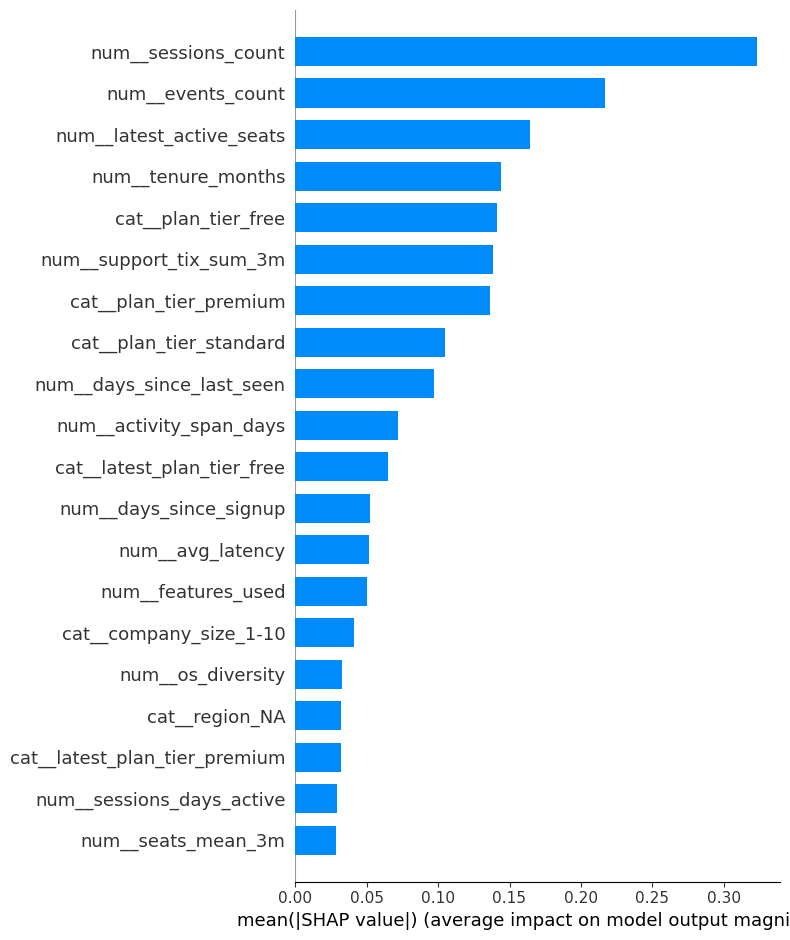

In [26]:
# !pip install shap
import shap
explainer_x = shap.TreeExplainer(xgb_f)
# sample to keep it quick
idx = np.random.choice(X_test_pre.shape[0], size=min(2000, X_test_pre.shape[0]), replace=False)
shap_vals_x = explainer_x.shap_values(X_test_pre[idx])
shap.summary_plot(shap_vals_x, X_test_pre[idx], feature_names=feat_names, plot_type="bar")


In [27]:
# y_prob should already exist from your ensemble on X_test_pre
def risk_tier(p):
    if p > 0.60:  return "High"
    if p >= 0.30: return "Medium"
    return "Low"

seg = pd.DataFrame({
    "user_id": X_test.index,
    "churn_prob": y_prob,
    "true": y_test
})
seg["risk_tier"] = seg["churn_prob"].map(risk_tier)

# Metrics per tier
tier_metrics = (seg.groupby("risk_tier")
                  .agg(users=("user_id","count"),
                       avg_prob=("churn_prob","mean"),
                       true_rate=("true","mean"))
                  .sort_values("avg_prob", ascending=False))
print(tier_metrics)

# Export
seg.sort_values("churn_prob", ascending=False).to_csv("churn_risk_segments.csv", index=False)
print("Saved churn_risk_segments.csv")


           users  avg_prob  true_rate
risk_tier                            
High         216  0.620570   0.398148
Medium      8973  0.449583   0.340912
Low        10811  0.155001   0.134400
Saved churn_risk_segments.csv


In [28]:
# Build a readable context table keyed by user_id, then align to test users
need = ["plan_tier","region","latest_mrr","features_used","sessions_per_week","days_since_last_seen"]

ctx = pd.DataFrame(index=feat.index)
if "plan_tier" in users.columns:
    ctx = ctx.join(users.set_index("user_id")[["plan_tier","region"]], how="left")
if "latest_mrr" in bill_latest_small.columns:
    ctx = ctx.join(bill_latest_small[["latest_mrr"]], how="left")
if "features_used" in evt_agg.columns:
    ctx = ctx.join(evt_agg[["features_used"]], how="left")
if "sessions_per_week" in sess_agg.columns:
    ctx = ctx.join(sess_agg[["sessions_per_week"]], how="left")
# days_since_last_seen was engineered in feat already
if "days_since_last_seen" in feat.columns:
    ctx = ctx.join(feat[["days_since_last_seen"]], how="left")

ctx = ctx[need].reindex(X_test.index)

high = seg[seg["risk_tier"]=="High"].merge(ctx, left_on="user_id", right_index=True, how="left")
med  = seg[seg["risk_tier"]=="Medium"].merge(ctx, left_on="user_id", right_index=True, how="left")

high.to_csv("campaign_high_risk.csv", index=False)   # deep outreach, discounts/CSM
med.to_csv("campaign_medium_risk.csv", index=False)  # nudges, onboarding tips
print("Saved campaign_high_risk.csv & campaign_medium_risk.csv")


Saved campaign_high_risk.csv & campaign_medium_risk.csv


ROC-AUC = 0.686 | PR-AUC = 0.344


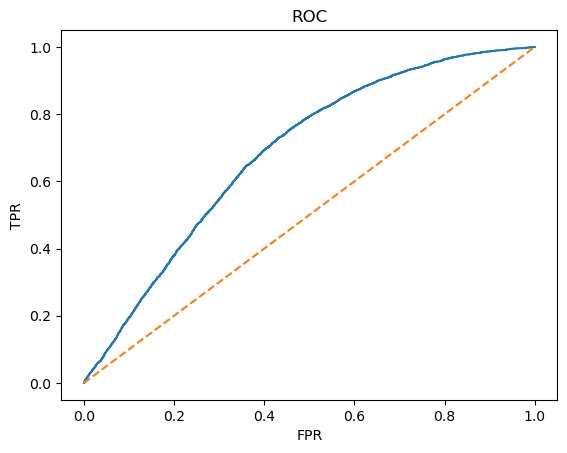

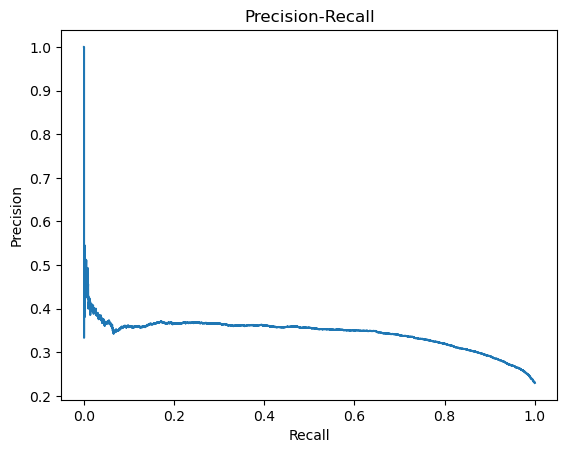

In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc  = average_precision_score(y_test, y_prob)
print(f"ROC-AUC = {roc_auc:.3f} | PR-AUC = {pr_auc:.3f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC");

# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall");


In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Choose operating threshold (e.g., the F1-optimal you already computed)
t_star = 0.35  # adjust to your chosen threshold
def cohort_report(col):
    df = pd.DataFrame({"g": X_test[col], "y": y_test, "p": y_prob})
    df["yhat"] = (df["p"] >= t_star).astype(int)
    rows = []
    for g, d in df.groupby("g"):
        tn, fp, fn, tp = confusion_matrix(d["y"], d["yhat"]).ravel()
        P = precision_score(d["y"], d["yhat"])
        R = recall_score(d["y"], d["yhat"])
        F1 = f1_score(d["y"], d["yhat"])
        rows.append({"group": g, "n": len(d), "precision": P, "recall": R, "f1": F1,
                     "tn": tn, "fp": fp, "fn": fn, "tp": tp})
    return pd.DataFrame(rows).sort_values("f1", ascending=False)

print("By plan_tier:\n", cohort_report("plan_tier").head(10))
print("By region:\n", cohort_report("region").head(10))


TypeError: '<' not supported between instances of 'int' and 'str'

In [31]:
def scenario_roi(y_prob, latest_mrr, top_frac=0.10, uplift_abs=0.10,
                 cost_per_user=2.0, horizon_months=3):
    """
    Treat top 'top_frac' users by predicted risk.
    Assume an absolute reduction in churn probability = uplift_abs for treated users.
    Approximate saved revenue = sum(delta_prob * MRR * horizon).
    """
    n = len(y_prob)
    k = max(1, int(top_frac * n))
    order = np.argsort(-y_prob)
    treat = order[:k]

    y_prob_new = y_prob.copy()
    y_prob_new[treat] = np.clip(y_prob_new[treat] - uplift_abs, 0, 1)

    delta = y_prob[treat] - y_prob_new[treat]
    saved_rev = float(np.nansum(delta * latest_mrr.iloc[treat].values) * horizon_months)
    cost = float(cost_per_user * k)
    return {"top_frac": top_frac, "treated": k,
            "avg_prob_treated": float(y_prob[treat].mean()),
            "expected_saved_rev": saved_rev, "contact_cost": cost,
            "net_impact": saved_rev - cost}

# Use latest_mrr aligned to test set
mrr_test = bill_latest_small["latest_mrr"].reindex(X_test.index).fillna(0)

scenarios = []
for frac in [0.05, 0.10, 0.15, 0.20]:
    scenarios.append(scenario_roi(y_prob, mrr_test, top_frac=frac,
                                  uplift_abs=0.10, cost_per_user=2.0, horizon_months=3))
pd.DataFrame(scenarios)


,top_frac,treated,avg_prob_treated,expected_saved_rev,contact_cost,net_impact
0,0.05,1000,0.583056,260.16,2000.0,-1739.84
1,0.10,2000,0.561611,612.00,4000.0,-3388.00
2,0.15,3000,0.545417,1263.60,6000.0,-4736.40
3,0.20,4000,0.531020,2037.36,8000.0,-5962.64
